In [1]:
import numpy as np
import pandas as pd
import string
import glob
from re import sub
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Caregando os dados e fazendo a análise

In [2]:
data = pd.concat(map(pd.read_csv, glob.glob('dataset/Sentimento/portuguese-tweets-for-sentiment-analysis/*.csv')))

In [3]:
data.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1038992008461930496,Esquerda e direita empatam na Suécia; ultranac...,Mon Sep 10 03:26:13 +0000 2018,Neutro,veja
1,1038873557902782465,Ao vivo: Estadão e TV Gazeta realizam terceiro...,Sun Sep 09 19:35:32 +0000 2018,Neutro,veja
2,1038869931398516736,FOTOS: Apoiadores de Jair Bolsonaro realizam a...,Sun Sep 09 19:21:07 +0000 2018,Neutro,veja
3,1038867128886198273,Barroso ameaça barrar propaganda se PT insisti...,Sun Sep 09 19:09:59 +0000 2018,Neutro,veja
4,1038859914339409920,Serena Williams é multada pelo comportamento d...,Sun Sep 09 18:41:19 +0000 2018,Neutro,veja


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900688 entries, 0 to 785813
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          900688 non-null  int64 
 1   tweet_text  900688 non-null  object
 2   tweet_date  900688 non-null  object
 3   sentiment   900688 non-null  object
 4   query_used  900688 non-null  object
dtypes: int64(1), object(4)
memory usage: 41.2+ MB


In [5]:
data = data[['tweet_text', 'sentiment']]

In [6]:
data

,tweet_text,sentiment
0,Esquerda e direita empatam na Suécia; ultranac...,Neutro
1,Ao vivo: Estadão e TV Gazeta realizam terceiro...,Neutro
2,FOTOS: Apoiadores de Jair Bolsonaro realizam a...,Neutro
3,Barroso ameaça barrar propaganda se PT insisti...,Neutro
4,Serena Williams é multada pelo comportamento d...,Neutro
...,...,...
785809,Acordar 8 horas é tão bom :),Positivo
785810,"@mayckcunha Olá, Mayck. Você já é cliente Clar...",Positivo
785811,Opa tava na merda mm e fiquei logo mais feliz ...,Positivo
785812,@andrebraga2806 Foi como a tua lealdade :),Positivo


In [7]:
data = data.drop_duplicates()

In [8]:
data

,tweet_text,sentiment
0,Esquerda e direita empatam na Suécia; ultranac...,Neutro
1,Ao vivo: Estadão e TV Gazeta realizam terceiro...,Neutro
2,FOTOS: Apoiadores de Jair Bolsonaro realizam a...,Neutro
3,Barroso ameaça barrar propaganda se PT insisti...,Neutro
4,Serena Williams é multada pelo comportamento d...,Neutro
...,...,...
785809,Acordar 8 horas é tão bom :),Positivo
785810,"@mayckcunha Olá, Mayck. Você já é cliente Clar...",Positivo
785811,Opa tava na merda mm e fiquei logo mais feliz ...,Positivo
785812,@andrebraga2806 Foi como a tua lealdade :),Positivo


In [9]:
data.columns = ['text','sentiment']

Negativo    541045
Positivo    285695
Neutro       52990
Name: sentiment, dtype: int64


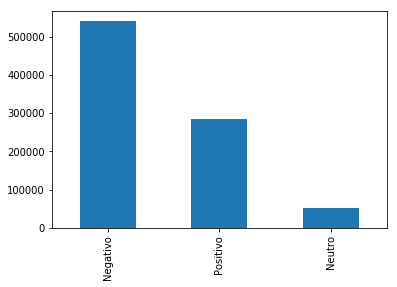

In [10]:
print(data.sentiment.value_counts())
data.sentiment.value_counts().plot(kind='bar')

# Limpando os dados

In [11]:
data.text = data.text.apply(lambda x: x.lower())
data.text = data.text.apply(lambda x: sub('(@[a-zA-z]+[a-zA-Z0-9-_]+)', '', x))
data.text = data.text.apply(lambda x: sub('(#[a-zA-Z]+[a-zA-A0-9-_]+)', '', x))
data.text = data.text.apply(lambda x: sub('rt', '', x))
data.text = data.text.apply(lambda x: sub('\<http.+?\>', '', x))
data.text = data.text.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
data.text = data.text.apply(lambda x: sub(' +', ' ', x))

/home/rafael/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
data

,text,sentiment
0,esquerda e direita empatam na suécia ultranaci...,Neutro
1,ao vivo estadão e tv gazeta realizam terceiro ...,Neutro
2,fotos apoiadores de jair bolsonaro realizam at...,Neutro
3,barroso ameaça barrar propaganda se pt insisti...,Neutro
4,serena williams é multada pelo compoamento dur...,Neutro
...,...,...
785809,acordar 8 horas é tão bom,Positivo
785810,olá mayck você já é cliente claro caso não se...,Positivo
785811,opa tava na merda mm e fiquei logo mais feliz ...,Positivo
785812,foi como a tua lealdade,Positivo


# Tamanho da sentença

In [13]:
tm = []
for t in data.text:
    tm.append(len(t.split(' ')))
tamanho_txt = np.max(tm)
tamanho_txt

85

# Token e Padding

In [14]:
tk = Tokenizer()
tk.fit_on_texts(data.text.values)
word_index = tk.word_index
total_palavras = len(word_index)+1
print('Total de palavras: ', total_palavras)

Total de palavras:  451307


In [15]:
# Frequência

minimo = 4
cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in tk.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if(value < minimo):
        cnt = cnt + 1
        freq = freq + value

print('Palavras raras: ', cnt)
print('Tamanho do vocabulário: ', tot_cnt)
print('Palavras mais comuns: ', tot_cnt-cnt)
total_palavras = tot_cnt-cnt

Palavras raras:  395630
Tamanho do vocabulário:  451306
Palavras mais comuns:  55676


In [16]:
tk = Tokenizer(tot_cnt-cnt)
tk.fit_on_texts(list(data.text))

In [17]:
x = tk.texts_to_sequences(data.text.values)
x = pad_sequences(x, maxlen = tamanho_txt, padding='post')
x.shape

(879730, 85)

In [18]:
y = pd.get_dummies(data.sentiment.values)
y.shape

(879730, 3)

# Separando os dados para treino e teste

In [19]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = .2)
print(x_treino.shape, y_treino.shape)
print(x_teste.shape, y_teste.shape)

(703784, 85) (703784, 3)
(175946, 85) (175946, 3)


# Defininfo o modelo

In [20]:

embedding_dim = 30

model = Sequential()
model.add(Embedding(total_palavras, embedding_dim, input_length=x.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(GlobalAveragePooling1D())
model.add(Dense(21, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 85, 30)            1670280   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 85, 30)            0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 21)                651       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 66        
Total params: 1,670,997
Trainable params: 1,670,997
Non-trainable params: 0
_________________________________________________________________


In [21]:
epochs = 100
batch_size = 128


filename = 'melhor_modelo.h5'
parada = EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)
check = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

modelo = model.fit(x_treino, y_treino, epochs=epochs, batch_size=batch_size, verbose=1,
                  validation_data=(x_teste, y_teste), callbacks=[check, parada])

/home/rafael/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 703784 samples, validate on 175946 samples
Epoch 1/100
703784/703784 [==============================] - 14s 20us/step - loss: 0.5320 - accuracy: 0.7645 - val_loss: 0.4324 - val_accuracy: 0.8136

Epoch 00001: val_loss improved from inf to 0.43238, saving model to melhor_modelo.h5
Epoch 2/100
703784/703784 [==============================] - 14s 20us/step - loss: 0.4253 - accuracy: 0.8175 - val_loss: 0.4154 - val_accuracy: 0.8217

Epoch 00002: val_loss improved from 0.43238 to 0.41542, saving model to melhor_modelo.h5
Epoch 3/100
703784/703784 [==============================] - 14s 19us/step - loss: 0.4052 - accuracy: 0.8260 - val_loss: 0.4113 - val_accuracy: 0.8236

Epoch 00003: val_loss improved from 0.41542 to 0.41134, saving model to melhor_modelo.h5
Epoch 4/100
703784/703784 [==============================] - 14s 19us/step - loss: 0.3935 - accuracy: 0.8318 - val_loss: 0.4154 - val_accuracy: 0.8232

Epoch 00004: val_loss did not improve from 0.41134
Epoch 5/100
703784/703784 

In [22]:
loss, acc = model.evaluate(x_teste, y_teste, verbose=0)
print('Acurácia: ', acc*100)

Acurácia:  82.44688510894775


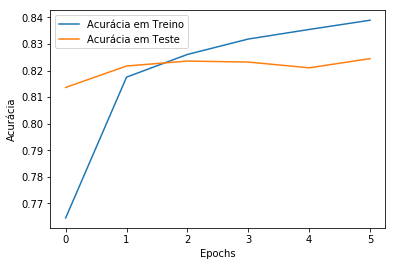

In [23]:
plt.plot(modelo.history['accuracy'])
plt.plot(modelo.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend(['Acurácia em Treino','Acurácia em Teste'])
plt.show()

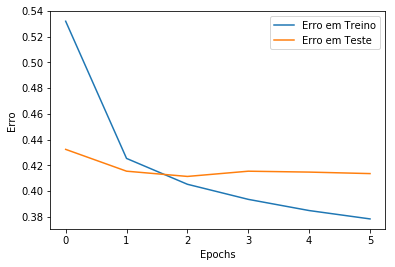

In [24]:
plt.plot(modelo.history['loss'])
plt.plot(modelo.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Erro')
plt.legend(['Erro em Treino','Erro em Teste'])
plt.show()